# Training the VMMR Cars Dataset with VGG16

Copyright (c) 2019 Intel Corporation.

Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Objective 
Understand the stages of preparing for training using the Keras with TensorFlow as a backend and the VGG16 topology. You will initiate training and learn about the relationship between accuracy and loss.  You will then learn about how to evalute your model, test out your model on a sample image and then freeze your model for use outside Keras.

# Activities 
**In this section of the training you will**
- Create DataGenerator for your dataset
- Learn about CPU Optimization for Tensorflow
- Understand Hyperparameter Selection
- Compile your model
- Learn about callbacks
- Start your training
- Evaluate Your Model
- Test Your Model on a sample image
- Freeze your graph

### Generate image data generators for training, validation and test data

![Load Data](assets/Training_1-1.png)

To ingest the data for training purposes we utilize the Keras **ImageDataGenerator** class.  This allows us to easily read in a directory that is structured with each category in its respective folder.  Earlier in the training during the Exploration phase we structured the data in this manner along with specific folders for train, test and validation.  We're going to utilize a generator for each of those folder classes.

At this point we also are planning to use **VGG16** which has a Height and Width requirement of **224x224** so we instantiate that here so we can utilize it throughout the rest of the notebook.  The generator will also resize images to that size before feeding it into training, testing or validation so we make sure it will work successfully.  

We're also using a **batch size** of 128 which is an ideal number for our system based on testing.  For your machine it might be different depending on how much memory you have access to.

### Activity

Click the cell below and then click **Run**.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

WIDTH=224
HEIGHT=224
BATCH_SIZE=64
test_dir = '../dataset/test/'
train_dir = '../dataset/train/'
val_dir = '../dataset/val/'

#Train DataSet Generator with Augmentation
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

#Validation DataSet Generator with Augmentation
print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

C:\Users\ukrida\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ukrida\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ukrida\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ukrida\AppData\Roaming\Python\Python36\s


Training Data Set
Found 3130 images belonging to 2 classes.

Validation Data Set
Found 446 images belonging to 2 classes.

Test Data Set
Found 897 images belonging to 2 classes.


### Optimizations for CPU

![CPU Optimization](assets/Training_1-2.png)

CPUs, which includes Intel® Xeon processors, achieve optimal performance when TensorFlow is built from source with all of the instructions supported by the target CPU.

Beyond using the latest instruction sets, Intel has added support for the Intel® Math Kernel Library for Deep Neural Networks (Intel® MKL-DNN) to TensorFlow. While the name is not completely accurate, these optimizations are often simply referred to as MKL or TensorFlow with MKL. TensorFlow with Intel MKL-DNN contains details on the Intel® MKL optimizations.

The two configurations listed below are used to optimize CPU performance by adjusting the thread pools.

- __intra_op_parallelism_threads__: Nodes that can use multiple threads to parallelize their execution will schedule the individual pieces into this pool.
- __inter_op_parallelism_threads__: All ready nodes are scheduled in this pool.

These configurations are set via the tf.ConfigProto and passed to tf.Session in the config attribute as shown in the snippet below. For both configuration options, if they are unset or set to zero, will default to the number of logical CPU cores. Testing has shown that the default is effective for systems ranging from one CPU with 4 cores to multiple CPUs with 70+ combined logical cores. A common alternative optimization is to set the number of threads in both pools equal to the number of physical cores rather than logical cores.
Intel MKL uses the following environment variables to tune performance:
- __KMP_BLOCKTIME__ - Sets the time, in milliseconds, that a thread should wait, after completing the execution of a parallel region, before sleeping.
- __KMP_AFFINITY__ - Enables the runtime library to bind threads to physical processing units.
- __KMP_SETTINGS__ - Enables (true) or disables (false) the printing of OpenMP* runtime library environment variables during program execution.
- __OMP_NUM_THREADS__ - Specifies the number of threads to use.

See Optimizing for CPU, 
https://www.tensorflow.org/performance/performance_guide#optimizing_for_cpu


### Activity
In the cell below, update **intra_op_parallelism_threads** to **8, OMP_NUM_THREADS** to **"8"**, **KMP_BLOCKTIME** to **"1"**, and then click **Run**.

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras import optimizers, models
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import tensorflow as tf
import os

NUM_PARALLEL_EXEC_UNITS = 8

#Set Performance Parameters for MKL and Tensorflow using Keras backend
#TensorFlow
config = tf.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)

session = tf.Session(config=config)
K.set_session(session)

#MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

### Selecting Hyperparamaters - Recommendations

![Hyperparameters](assets/Training_1-3.png)

#### What batch size?
A batch size is the subset of the training dataset that is utilized in one iteration.
It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize. 
The lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function.

In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256.
Batch size below 32 might get too slow because of significantly lower computational speed as a result of not exploiting vectorization to the full extent.

https://arxiv.org/abs/1609.04836

#### What Learning rate to use? :
The __Learning Rate__ is the size of the steps we take to reach a (local) minimum.
A lower learning rate means more steps and therefore trains for a longer time while higher learning rate means less steps which therefore trains for shorter time.
Also, too low a learning rate never progresses, and too high a learning rate causes instability and never converges. In between, there is a band of “just right” learning rates that successfully train.

There is no single learning rate that works for all optimizers.
Learning rate can affect training time by an order of magnitude.
Learning rate performance did not depend on model size. The same rates that performed best for 1x size performed best for 10x size.

#### Why and what optimizer to use?
Gradient Descent is one of the most popular algorithms to perform optimization and by far the
most common way to optimize neural networks. __Stochastic Gradient Descent(SGD)__ is a variant of Gradient Descent in which only a few of the samples (selected by batch_size) are used to compute gradient in every iteration. SGD can be optimized with parameter __'Momentum'__ which is a method that helps accelerate SGD in the relevant direction and dampens
oscillations.

One of the challenges of __SGD__ is that the same learning rate applies to all parameter updates. 
If the dataset is sparse and the features have very different frequencies, it will not be necessary to update all of them to the same extent, but rather a larger update for rarely occurring features. This problem is addressed by __Adaptive Learning-Rate optimizers__ (Adagrad, Adadelta, RMSprop and Adam) that adapt the learning
rate to the parameters, performing larger updates for infrequent and smaller updates for frequent
parameters.

The main down side of the __Adaptive Learning Rate optimizers__ is that they require more computation to be performed for each parameter in each training step and more state to be retained for each parameter.
While a simple __SGD__ Optimizer could equally be used with less computational requirements, it would require more hyperparameter tuning (__learning rate__) before it would converge as quickly.

In all, most of the optimizers manage to converge in a reasonable time.

https://arxiv.org/pdf/1609.04747.pdf

### What is Transfer Learning?

Transfer learning is taking the weights from a previously trained network and use them as the basis for the weights in a new network.  Since there is a difference in number of categories between data sets we normally remove the top layers of the network and re-instantiate them to match the number of categories we're trying to choose between.  Using Transfer Learning will significantly speed up your training process by utilizing things like edge detection that the previous training has already learned then you can fine tune the network to your data set.

A commonly used transfer learning base is the ImageNet data set weights.

"What is ImageNet?
ImageNet is an image dataset organized according to the WordNet hierarchy. Each meaningful concept in WordNet, possibly described by multiple words or word phrases, is called a "synonym set" or "synset". There are more than 100,000 synsets in WordNet, majority of them are nouns (80,000+). In ImageNet, we aim to provide on average 1000 images to illustrate each synset. Images of each concept are quality-controlled and human-annotated. In its completion, we hope ImageNet will offer tens of millions of cleanly sorted images for most of the concepts in the WordNet hierarchy."

http://image-net.org/about-overview

### Initialize Training Top Layers

Start by brining in the pre-defined **VGG16** network provided by Keras.  We'll make sure to include the **imagenet** weights since we want to utilize those weights for Transfer Learning which will speed up our training significantly.  We'll also make sure the **Top Layers** aren't included since we don't want to predict 1001 classes and will then modify the network to fit our dataset.

Take the base model and add a **GlobalAveragePooling2D** layer and pass it the output of the base model.  We'll then add a final **Dense Layer** that has a **softmax activation** which will do our predictions on the number of classes in our dataset.  To make sure this is verstile we use the train_flow generator class indicies number so that it will automatically use the correct number of classes in the dataset.

Now we iterate over the initial layers of the base model and **disable them for training** by changing the **layer.trainable** variable to False.  This means we'll only train over the new layers that we added specifically for our dataset.

Then compile your model and add the optimizer that you want to use.  In this case we'll be using **Adam** with a **Learning Rate** of **0.001**.  We also want to use **loss** of **Categorical Crossentropy** since we have a multi-class classification problem.

We can print out the summary of the network after compiling so that we can verify the total number of nodes needing to be training and that the last layers were correctly added to the network.

![Compile Model](assets/Training_1-4.png)

### Activity

Click the cell below and then click **Run**.

In [3]:
# Initialize VGG16 with transfer learning
base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))

# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)
# and a dense layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy', 'binary_accuracy'], loss='binary_crossentropy')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_______________________________________________

### Start Training / Training Callbacks

![Callback and Training](assets/Training_1-5.png)

To start our training we're going to utilize the Keras Fit Generator method.  This will allow us to pass in the ImageDataGenerator/flow_from_directory structure from above directly to the method.  Here is where we can also set our epochs, validation set, and callbacks.

Setting an epoch count can really depend on the dataset that you're using and how long you're willing to wait for the training to complete.  During out testing phase we ended up trying 100 epoch's and utilizing Callbacks to make sure that we're not overfitting.

It's useful to have a **validation set** that you can try to maximize toward when doing your training.  This way you have an idea of how well things are going on a small subset of data that isn't the test set.  If you use the test set for this purpose it will be harder to tell if you're generalizing well or if you're only fitting to the test set specifically and won't do well in a real world test.  Earlier in the notebook we insantiated a validation set generator which we can pass in here by setting the generator to the validation_data paramter.

We need to specify both the validation and training number of steps per epoch.  We can use variables defined in our generators so that we're not hard coding numbers directly in these fields.  This is done by taking our sample size and dividing by our batch size then utilizing the math.ceil function so we properly account for the final smaller batch in the dataset.

Lastly, we define 4 different callbacks that we're going to use during our training.  Callbacks are called after an epoch of training is complete and then will perform whatever action is necessary.

### Callbacks

**ModelCheckpoint**: Used to save our checkpoint based on a certain set of criteria.  In this case we're monitor our loss and looking for the min value.  After an epoch it will check to see if the loss is lower than the previous epoch of training and if so then to save the model to disk.  We're also indicating that we want to save only the best model so the previous model will be overwritten.  This will minimize the amount of disk space taken up by models.

**TensorBoard**: Utilizing this checkpoint will write out the tf.events file during training so we can view them in TensorBoard.  We need to indicate a location for the logs to be saved and the update frequence for which we want the data.  In our case we're asking for batch frequence data so we need to also pass in the batch size to the function.  We can then start Tensorboard and point the --logdir parameter at the directory where the logs are saved to see how our training is going.

**EarlyStopping**: This is used to make sure that we're not overtraining and overutilizing our compute.  It will monitor a metric after every epoch and see how much it has changed since the previous epoch.  If it hasn't changed significantly over the last n number of epochs it will end the training prematurely since there isn't much gain from going further.  In this case we're monitoring loss and asking for it to minimize the value, we also give a patience value of 5 which means the value has to not change significantly for 5 epochs before the training will be stopped.

**CSVLogger**: Another logging technique that can be easier to read by directly inspecting the log file.  This can be useful if you're not interested in using TensorBoard or just want to use a simpler logging output.  It will write out the metrics we're keeping track of during training and append them to the CSV file giving during the instanitation of the callback.

### Activity

Click the cell below and then click **Run**.

In [4]:
import math
top_layers_file_path="top_layers.vgg16.hdf5"

checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('logs/vgg16-log.csv', append=True)

history = model.fit_generator(train_flow, 
                              epochs=5, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

Epoch 1/5
48/49 [============================>.] - ETA: 14s - loss: 0.1286 - acc: 0.9677 - binary_accuracy: 0.9677
Epoch 00001: loss improved from inf to 0.12591, saving model to top_layers.vgg16.hdf5
49/49 [==============================] - 809s 17s/step - loss: 0.1261 - acc: 0.9682 - binary_accuracy: 0.9682 - val_loss: 0.0392 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 2/5
48/49 [============================>.] - ETA: 14s - loss: 0.0137 - acc: 0.9964 - binary_accuracy: 0.9964
Epoch 00002: loss improved from 0.12591 to 0.01344, saving model to top_layers.vgg16.hdf5
49/49 [==============================] - 798s 16s/step - loss: 0.0134 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0330 - val_acc: 0.9899 - val_binary_accuracy: 0.9899
Epoch 3/5
48/49 [============================>.] - ETA: 14s - loss: 0.0154 - acc: 0.9966 - binary_accuracy: 0.9966
Epoch 00003: loss did not improve from 0.01344
49/49 [==============================] - 800s 16s/step - loss: 0.0151 - acc: 0

### Evaluate Model

![Evaluate Model](assets/Training_1-6.png)

To evaluate our training results we can use the **evaluation generator**.  This will integrate well with our data generator from the previous step that points to our testing set.  We will again have to specify the amount of steps used by calculating with samples and batch size and indicated earlier.

We're also going to receive three different results from our evaluate generator: **loss**, **accuracy** and **top k accuracy**.  These are given since when we compiled our model we indicated that we're evaluting for **categorical crossentropy** for **loss** and our **metrics** were **accuracy** and **top_k_categorical_accuracy** which will evaluate if our result was in the top 5 confidence.  If we added or removed a metric during compiliation it would be reflected here in our evaluation generator and we would get more or less values in return from this function.

### Activity

Click the cell below and then click **Run**.

In [5]:
model.load_weights(top_layers_file_path)
loss, acc, top_5 = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
print("Loss: ", loss)
print("Acc: ", acc)
print("Top 5: ", top_5)

15/15 [==============================] - 198s 13s/step - loss: 0.1378 - acc: 0.9548 - binary_accuracy: 0.9548
Loss:  0.1378315817322194
Acc:  0.9548495
Top 5:  0.9548495


### Write Labels File

In Deep learning, when we're training our network we're using a numerical value for the actual class that is predicated at the end of each batch through the network.  The network itself doesn't care what the actual string class name is, only that it's optimizing for one of the n classes you have in your dataset.  

So when we move forward and use our network we need to indicate what numerical value the network was using to represent the correct class name.  We can do this by iterating over any of the data generator class_indicies values and use a list comprehension to extract the values.  We're going to write these values out in order to a text file to represent the numerical value mapping to class name for future use.

### Activity

Click the cell below and then click **Run**.

In [6]:
label = [k for k,v in train_flow.class_indices.items()]
with open('vgg16-labels.txt', 'w+') as file:
    file.write("\n".join(label))

### Test Model with Sample image

![Test Model](assets/Training_1-7.png)

Now that we're done training we want to see the results for our model on a test image.  We're going to load a random image chosen from our test set and run it through the model.

We can use Keras to load the image and resize it to the given size required for the network.  We then need to convert the Image object to an array and add an extra axis to the array so it's in the format (n, h, w, c).  Then it will be run through the preprocessing step required for all inputs into the network and passed into the model.predict run for the results.

After running the image through the model for a prediction we need to map the indicies to the correct class names and we can also take a look at the confidence values returned by the softmax.  

To do this we'll start by sorting the prediction results by index.  Then we can get the top X number of values from the end of the array and then we'll reorder the array in the reverse order since the highest confidence is the last value in the array.  We can then use this array to read the confidence and label of the top X results.

### Activity

Click the cell below and then click **Run**.

In [7]:
from tensorflow.keras.preprocessing import image
import numpy as np
import glob
import random

file_list = glob.glob("../dataset/test/*/*")
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
print("Image Category: ", img_cat)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print("Raw Predictions: ", preds)

top_x = 3
top_args = preds[0].argsort()[-top_x:][::-1]
preds_label = [label[p] for p in top_args]
print("\nTop " + str(top_x) + " confidence: " + " ".join(map(str, sorted(preds[0])[-top_x:][::-1])))
print("Top " + str(top_x) + " labels: " + " ".join(map(str, preds_label)))

Image Category:  without_mask
Raw Predictions:  [[8.516235e-06 9.999896e-01]]

Top 3 confidence: 0.9999896 8.516235e-06
Top 3 labels: without_mask with_mask


### Transform Keras Model to Tensorflow Frozen Graph

![Freeze Graph](assets/Training_1-8.png)

Keras utilizes the h5 or hdf5 file format when saving its model.  If we want to use our model outside of Keras, in **OpenVINO**, we need a frozen pb file to pass in when using a Tensorflow model.  We can do that directly from Keras by utilizing the below functions.

First we need to make sure that you set the learning phase to 0 or you might end up not correctly getting the output node from the session.  Then we grab the session and output names and pass them to graph_util.convert_variables_to_constants.

"If you have a trained graph containing Variable ops, it can be convenient to convert them all to Const ops holding the same values. This makes it possible to describe the network fully with a single GraphDef file, and allows the removal of a lot of ops related to loading and saving the variables."
https://www.tensorflow.org/api_docs/python/tf/graph_util/convert_variables_to_constants

and then we pass that constant graph to graph_io.write_graph which writes the graph proto to a file.

### Activity

Click the cell below and then click **Run**.

In [8]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

input_model_path = top_layers_file_path
output_model_name = "top_layers.vgg16.pb"
output_model_dir = "tf_model"

K.set_learning_phase(0)
sess = K.get_session()

test_model = models.load_model(input_model_path)
orig_output_node_names = [node.op.name for node in test_model.outputs]

constant_graph = graph_util.convert_variables_to_constants(
    sess,
    sess.graph.as_graph_def(),
    orig_output_node_names)
graph_io.write_graph(
    constant_graph,
    output_model_dir,
    output_model_name,
    as_text=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 30 variables.
INFO:tensorflow:Converted 30 variables to const ops.


'tf_model\\top_layers.vgg16.pb'

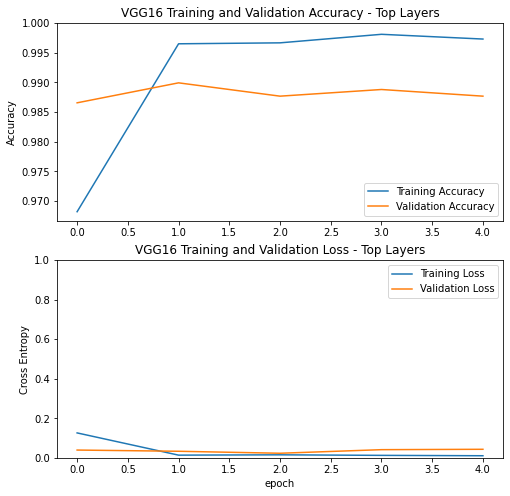

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('VGG16 Training and Validation Accuracy - Top Layers')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('VGG16 Training and Validation Loss - Top Layers')
plt.xlabel('epoch')
plt.show()

### Summary - Initial Training Done

You've learned about the following:
- Create DataGenerator for your dataset
- Learn about CPU Optimization for Tensorflow
- Understand Hyperparameter Selection
- Compile your model
- Learn about callbacks
- Start your training
- Evaluate Your Model
- Test Your Model on a sample image
- Freeze your graph

We've now completed the first round of training!  You can now utilize the frozen graph from the end of this section to run inference with through OpenVINO.  

# Optional - Additional Training for the Entire Network

### Fine Tuning the Entire Network

We previously fine tuned only the top layer of the network.  Now we're going to allow for all of the layers in the network to be trained but we're going to use a lower learning rate.  This will let the network narrow in and tune the remaining weights we didn't tune from the ImageNet checkpoint.

We'll start by unfreezing all the layers in our model and then compiling the model again.  The remaining pieces of the code will be almost identical to the above except that we're making sure to indicate file path names that indicate we're utilizing all the nodes in this training.

In [10]:
model = load_model(top_layers_file_path)

# unfreeze all layers
for layer in model.layers:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy', 'binary_accuracy'], loss='binary_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
#Start Training top layers
all_nodes_file_path="all_layers.vgg16.hdf5"
checkpoint = ModelCheckpoint(all_nodes_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

train_flow.reset()
val_flow.reset()
history = model.fit_generator(train_flow, 
                              epochs=5, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

Epoch 1/5
48/49 [============================>.] - ETA: 55s - loss: 1.0627 - acc: 0.8120 - binary_accuracy: 0.8120 
Epoch 00001: loss improved from inf to 1.04336, saving model to all_layers.vgg16.hdf5
49/49 [==============================] - 2848s 58s/step - loss: 1.0426 - acc: 0.8153 - binary_accuracy: 0.8153 - val_loss: 0.6285 - val_acc: 0.6816 - val_binary_accuracy: 0.6816
Epoch 2/5
48/49 [============================>.] - ETA: 55s - loss: 0.0791 - acc: 0.9729 - binary_accuracy: 0.9729 
Epoch 00002: loss improved from 1.04336 to 0.07783, saving model to all_layers.vgg16.hdf5
49/49 [==============================] - 2807s 57s/step - loss: 0.0779 - acc: 0.9732 - binary_accuracy: 0.9732 - val_loss: 0.2667 - val_acc: 0.9148 - val_binary_accuracy: 0.9148
Epoch 3/5
48/49 [============================>.] - ETA: 54s - loss: 0.0450 - acc: 0.9850 - binary_accuracy: 0.9850 
Epoch 00003: loss improved from 0.07783 to 0.04545, saving model to all_layers.vgg16.hdf5
49/49 [=======================

In [12]:

#Load Trained Model and Test
model.load_weights(all_nodes_file_path)
test_flow.reset()
loss, acc, top_5 = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
print("Loss: ", loss)
print("Acc: ", acc)
print("Top 5: ", top_5)

15/15 [==============================] - 197s 13s/step - loss: 0.4708 - acc: 0.7486 - binary_accuracy: 0.7486
Loss:  0.4707621852556864
Acc:  0.74860644
Top 5:  0.74860644


In [13]:
file_list = glob.glob("../dataset/test/*/*")
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
print("Image Category: ", img_cat)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print("Raw Predictions: ", preds)

top_x = 3
top_args = preds[0].argsort()[-top_x:][::-1]
preds_label = [label[p] for p in top_args]
print("\nTop " + str(top_x) + " confidence: " + " ".join(map(str, sorted(preds[0])[-top_x:][::-1])))
print("Top " + str(top_x) + " labels: " + " ".join(map(str, preds_label)))

Image Category:  without_mask
Raw Predictions:  [[6.5998993e-06 9.9999428e-01]]

Top 3 confidence: 0.9999943 6.5998993e-06
Top 3 labels: without_mask with_mask


In [14]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

input_model_path = all_nodes_file_path
output_model_name = "all_layers.vgg16.pb"
output_model_dir = "tf_model"

K.set_learning_phase(0)
sess = K.get_session()

test_model = models.load_model(input_model_path)
orig_output_node_names = [node.op.name for node in test_model.outputs]

constant_graph = graph_util.convert_variables_to_constants(
    sess,
    sess.graph.as_graph_def(),
    orig_output_node_names)
graph_io.write_graph(
    constant_graph,
    output_model_dir,
    output_model_name,
    as_text=False)

INFO:tensorflow:Froze 30 variables.
INFO:tensorflow:Converted 30 variables to const ops.


'tf_model\\all_layers.vgg16.pb'

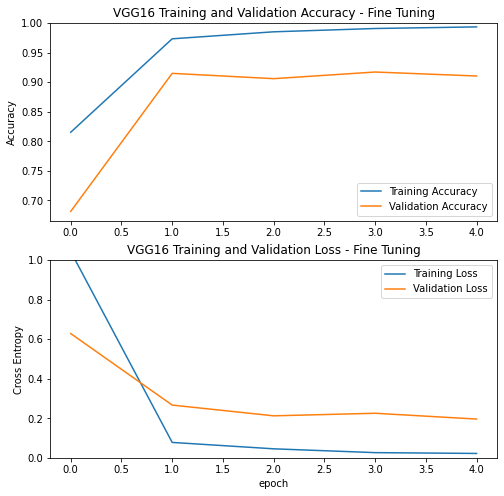

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('VGG16 Training and Validation Accuracy - Fine Tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('VGG16 Training and Validation Loss - Fine Tuning')
plt.xlabel('epoch')
plt.show()

In [24]:
from tensorflow.keras.utils import plot_model
#plot_model(arima_model, to_file='arima_model.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='VGG16_model.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Resources

TensorFlow* Optimizations on Modern Intel® Architecture, https://software.intel.com/en-us/articles/tensorflow-optimizations-on-modern-intel-architecture

Intel Optimized TensorFlow Wheel Now Available, https://software.intel.com/en-us/articles/intel-optimized-tensorflow-wheel-now-available

Build and Install TensorFlow* on Intel® Architecture, https://software.intel.com/en-us/articles/build-and-install-tensorflow-on-intel-architecture

TensorFlow, https://www.tensorflow.org/

### Case Studies

Manufacturing Package Fault Detection Using Deep Learning, https://software.intel.com/en-us/articles/manufacturing-package-fault-detection-using-deep-learning

Automatic Defect Inspection Using Deep Learning for Solar Farm, https://software.intel.com/en-us/articles/automatic-defect-inspection-using-deep-learning-for-solar-farm
